In [2]:
%load_ext autoreload 
%autoreload 2
import NN
import MC
import plot_class

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch.nn as nn
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Exercise 1.1

In [3]:
#define all matrices of the stochastic problem
H = torch.tensor([[1.2, 0.8], [0.7, 1.0]], dtype = torch.float32)
M = torch.tensor([[1.0, 0.2], [0.1, 1.0]], dtype = torch.float32)
C = torch.eye(2, dtype = torch.float32) * 2.0
D = torch.eye(2, dtype = torch.float32)
R = torch.eye(2, dtype = torch.float32) * 5.0
s = torch.tensor([[0.01, 0.04]], dtype = torch.float32)

T = 0.5
t0 = 0.1

#define class "LQR" that calculates value function and optimal control (both analytically with ricatti solution and with Monte-Carlo simulations)
LQR = MC.LQR(H, M, s, C, D, T, R)

In [3]:
#Ricatti ODE Solution
N = 500
t_grid = torch.linspace(t0, T, int(N)+1)
ricatti_sol = LQR.solve_ricatti_ode(t_grid)

In [4]:
#Value function calculation
batch_size = 4
space = torch.rand(batch_size, 1, 2, dtype = torch.float32) * 6
time = torch.rand(batch_size) * T 

u_arr = LQR.calculate_value(time, space)
print(u_arr[:3])

tensor([67.8594, 57.6528, 31.0286])


In [5]:
#Optimal control calculation
batch_size = 3
space = torch.rand(batch_size, 1, 2, dtype = torch.float32) * 6
time = torch.rand(batch_size) * T 

a_arr = LQR.calculate_control(time, space)
print(a_arr[:3])

tensor([[ -4.8785, -16.4152],
        [ -9.0263,  -8.2252],
        [-11.0169,  -7.3080]])


### Exercise 1.2

In [6]:
#Comparison between MC and Analytical methods
for i in range(5):
    batch_size = 1
    space = torch.rand(batch_size, 1, 2, dtype = torch.float32) * 6 - 3

    time = torch.tensor([0.1], dtype = torch.float32)

    val = LQR.calculate_value(time, space)
    val1 = LQR.calculate_control(time, space)

    J_arr = LQR.mc_high_dim(time, space, N=500, N_mc=500)
    print(torch.mean(J_arr), val)

tensor(4.1327) tensor([4.1506])
tensor(39.6625) tensor([39.6568])
tensor(12.3826) tensor([12.3477])
tensor(21.8024) tensor([21.8789])
tensor(30.2896) tensor([30.3847])


In [2]:
#Define one input (t, x) - current position of the system for which the plots below are created
batch_size = 1
space = torch.rand(batch_size, 1, 2, dtype = torch.float32) * 6 - 3
time = torch.tensor([0.1], dtype = torch.float32)

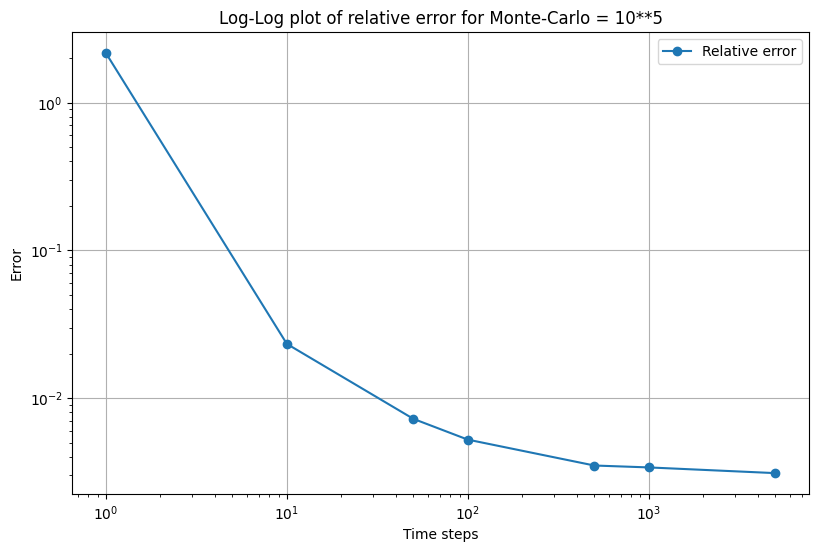

In [8]:
t_arr = [1, 10, 50, 100, 500, 1000, 5000]
mc_arr = [int(10**5)]

error_arr = LQR.error_calculation(time = time, space = space, time_arr = t_arr, mc_arr = mc_arr)

fig, ax = plt.subplots()
plt.loglog(t_arr, error_arr, marker='o', linestyle='-', label = 'Relative error')
plt.xlabel('Time steps')
plt.ylabel('Error')
plt.title('Log-Log plot of relative error for Monte-Carlo = 10**5')
plt.grid(True)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(9.5)
plt.show()

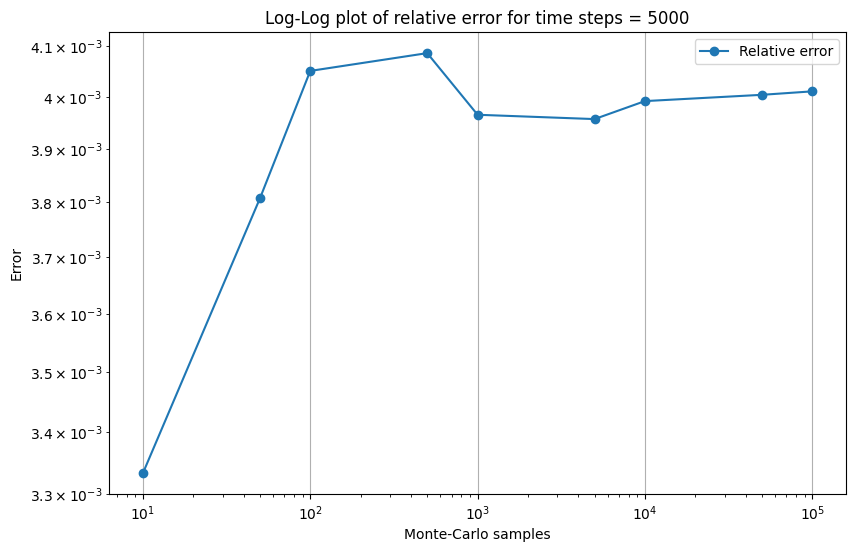

In [5]:
t_arr = [5000]
mc_arr = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

error_arr = LQR.error_calculation(time = time, space = space, time_arr = t_arr, mc_arr = mc_arr)

fig, ax = plt.subplots()
plt.loglog(mc_arr, error_arr, marker='o', linestyle='-', label = 'Relative error')
plt.xlabel('Monte-Carlo samples')
plt.ylabel('Error')
plt.title('Log-Log plot of relative error for time steps = 5000')
plt.grid(True)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(9.5)
plt.show()

### Exercise 2.1

In [6]:
batch_size = 100 #data size = {(t1, X1), ..., (t100, X100)}

dim_x = 2 #X_i = [x1_i, x2_i]
hidden_layer_size = 100  # Adjusted hidden layer size

#Define neural network, optimiser and loss function
model_value = NN.Net_DGM(dim_x, hidden_layer_size, activation='Tanh')
optimiser = torch.optim.Adam(model_value.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

#Data normalisation
time, space, time_val, space_val, v, v_val = LQR.data_processing(batch_size, 'Value')
losses = []
losses_val = []

# Training loop
num_epochs = 1000  # Adjust as needed
for epoch in range(num_epochs):
    optimiser.zero_grad()

    # Forward pass
    output = model_value(time, space)
    output_val = model_value(time_val, space_val)

    # Compute loss
    loss = criterion(output, v)  
    losses.append(loss.item())

    loss_val = criterion(output_val, v_val)
    losses_val.append(loss_val.item())
    
    loss.backward()
    optimiser.step()

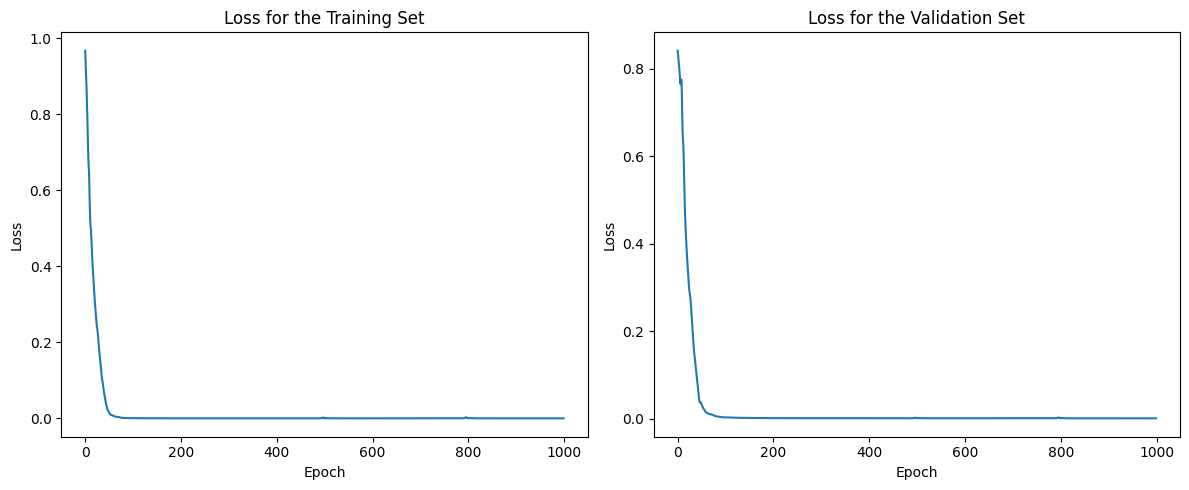

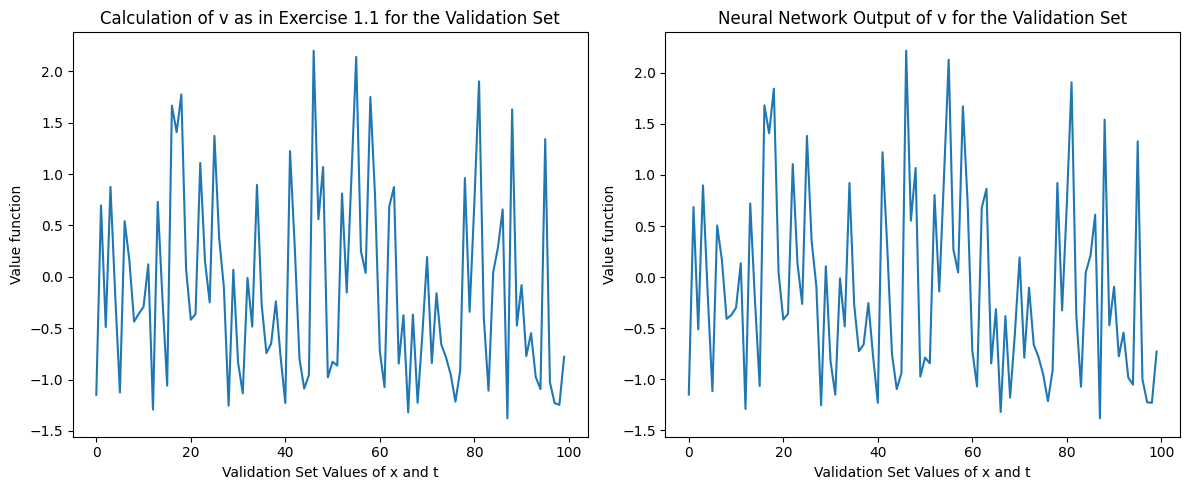

In [7]:
#Loss plots
plot_class.plot1(losses, losses_val, output_val, v_val)

We can see that the loss for the training and validation set go down to zero. The calculation of v in exercise 1.1. and the neural network output look identical.

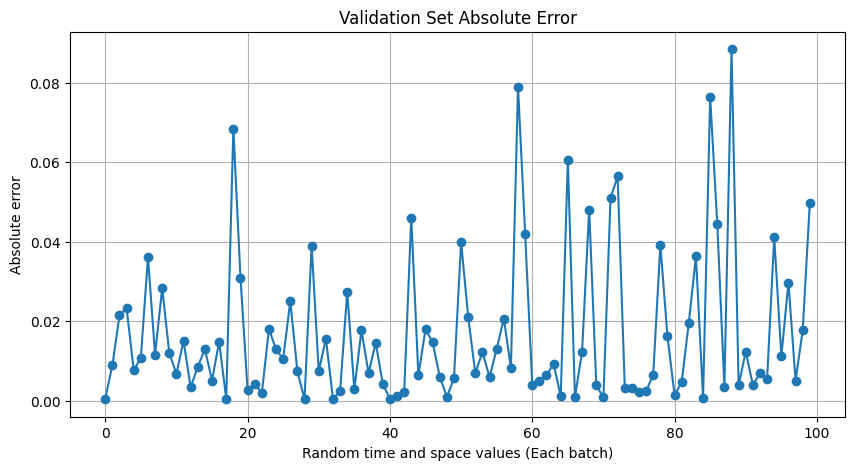

In [9]:
#Absolute error plot
plot_class.plot2(output_val, v_val)

The absolute error is very small.

### Exercise 2.2

In [3]:
batch_size = 200 #data size = {(t1, X1), ..., (t200, X200)}

dim_x = 2 #X_i = [x1_i, x2_i]
hidden_layer_size = 100  # Adjusted hidden layer size

#Define neural network, optimiser and loss function
model_control = NN.FFN([3, hidden_layer_size, hidden_layer_size, 2],  batch_norm=False)
optimiser = torch.optim.Adam(model_control.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

#Data normalisation
time, space, time_val, space_val, a, a_val = LQR.data_processing(batch_size, 'Control')
a = a.squeeze(1)
a_val = a_val.squeeze(1)

losses = []
losses_val = []

# Training loop
num_epochs = 1000  # Adjust as needed
for epoch in range(num_epochs):
    optimiser.zero_grad()

    # Forward pass
    arg = torch.cat([time,space], 1)
    output = model_control(arg)
    arg_val = torch.cat([time_val,space_val], 1)
    output_val = model_control(arg_val)

    # Compute loss
    loss = criterion(output, a)  
    losses.append(loss.item())

    loss_val = criterion(output_val, a_val)
    losses_val.append(loss_val.item())

    loss.backward()
    optimiser.step()


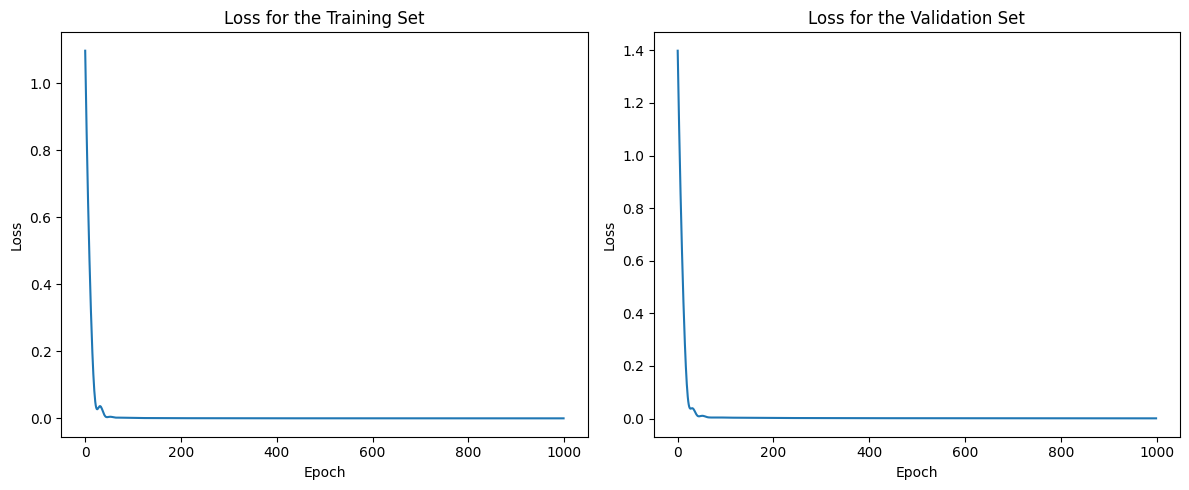

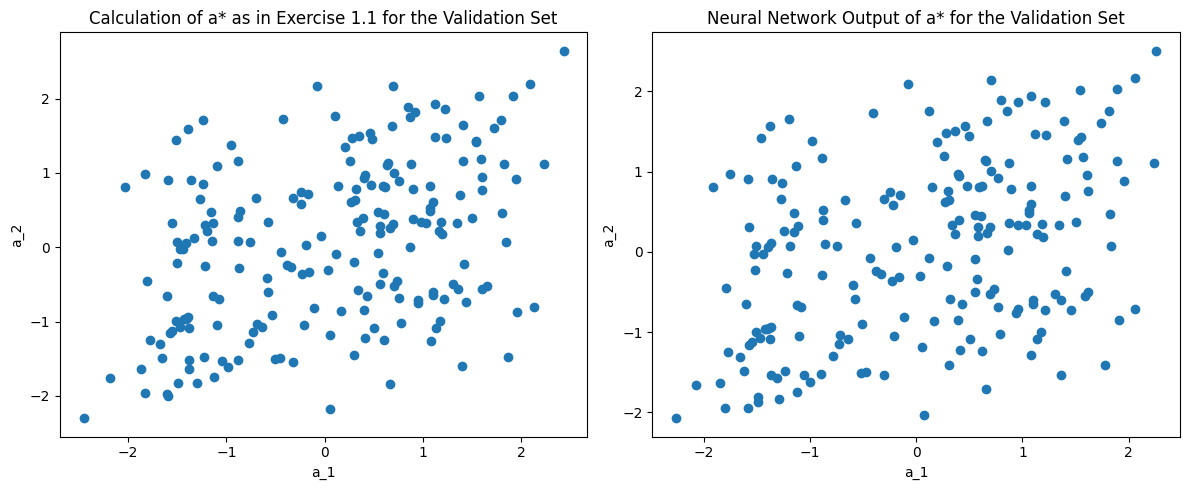

In [4]:
plot_class.plot3(losses, losses_val, output_val, a_val)

The loss of the training and validation set go down towards zero. The scatterplots of a1 vs a2 for exercise 1.1. and the neural network look very similar.

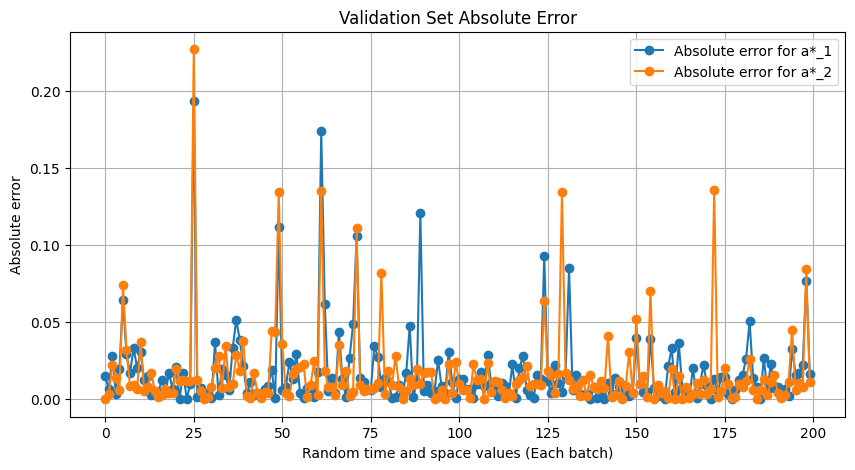

In [5]:
#Absolute error plot
plot_class.plot4(output_val, a_val)

The absolute errors are relatively low.

### Exercise 3.1

In [41]:
dim_x = 2
hidden_layer_size = 150  # Adjusted hidden layer size
batch_size = 400 #training data size
num_epochs = 4500 #trainig iterations until convergence
    
model_dgm = NN.Net_DGM(dim_x, hidden_layer_size, activation='Tanh')

optimiser = torch.optim.Adam(model_dgm.parameters(), lr=0.01) #Adam method
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones = (1000, 3800 ),gamma=0.2) #adaptive learning rate
criterion = torch.nn.MSELoss() #MSE loss

a = torch.ones(batch_size, 2, 1).float()

losses, error_arr = [], []
target_functional = torch.zeros(batch_size)

RR, HH, CC, MM, DD, SS = LQR.params(batch_size) #multidim matrices 

for p in tqdm(range(num_epochs+1)):
    optimiser.zero_grad()
    
    space = torch.rand(batch_size, 2, dtype=torch.float32, requires_grad=True) * 12 - 6 #data, x
    time = torch.rand(batch_size, 1, dtype = torch.float32, requires_grad=True) * T #data, t
    space_d = space.unsqueeze(1).detach()

    u_of_tx = model_dgm(time, space)
    grad_u_x = NN.get_gradient(u_of_tx, space).unsqueeze(1) #du/dx
    grad_u_t = NN.get_gradient(u_of_tx, time).unsqueeze(1) #du/dt
    dxx = NN.get_hessian(grad_u_x.squeeze(1), space).unsqueeze(1) #duu/dxx
    
    trace_matr = SS @ dxx.squeeze(1)
    trace = np.trace(trace_matr.detach().numpy(), axis1=1, axis2 = 2)
    pde = grad_u_t + 0.5 * torch.tensor(trace).reshape(-1, 1, 1) + grad_u_x @ HH @ space_d.reshape(-1, 2, 1) + grad_u_x @ MM @ a + space_d @ CC @ space_d.reshape(-1, 2, 1) + a.reshape(-1, 1, 2) @ DD @ a
    pde = torch.flatten(pde) #NN pde estimate value inside domain 
    
    u_of_Tx = model_dgm(torch.tensor([T]).repeat(batch_size, 1), space) #true pde on the boundary
    target_terminal = (space_d @ RR.float() @ space_d.reshape(batch_size, 2, 1)).reshape(batch_size, 1) #NN estimate on the boundary
    
    MSE_functional = criterion(pde, target_functional) #NN estimate inside vs zeros
    MSE_terminal = criterion(u_of_Tx, target_terminal) #NN estimate on the boundary vs terminal value 

    loss = MSE_functional + MSE_terminal #total loss
    losses.append(loss.item())
    
    loss.backward() #gradient calculation 
    optimiser.step() #parameters update
    scheduler.step()
    
    if round(p % 900) == 0: #validation NN vs MC value functions relative error
        n = 50
        mc_arr = torch.ones(n)
        space_test = torch.rand(n, 2, dtype=torch.float32) * 6 - 3
        time_test = torch.rand(n, 1, dtype = torch.float32) * T
        for j in range(n):
            mc_arr[j] = torch.mean(LQR.monte_carlo_v1(time_test[j], space_test[j].reshape(1, 1, 2).type(torch.float32), N=300, N_mc=100, a1 = True))
        error_val = NN.error_fun(torch.flatten(model_dgm(time_test, space_test).detach()), mc_arr)
        error_arr.append(error_val.item())
        

100%|██████████| 4501/4501 [07:18<00:00, 10.27it/s] 


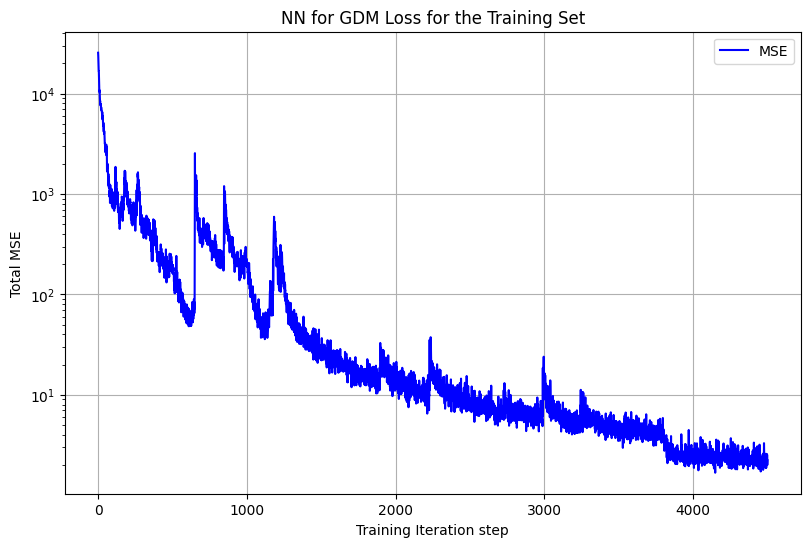

In [42]:
fig, ax = plt.subplots()
plt.semilogy(np.arange(num_epochs+1), losses, linestyle='-', label = 'MSE', color = 'b')
plt.xlabel('Training Iteration step')
plt.ylabel('Total MSE')
plt.title('NN for GDM Loss for the Training Set')
plt.grid(True)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(9.5)
plt.show()

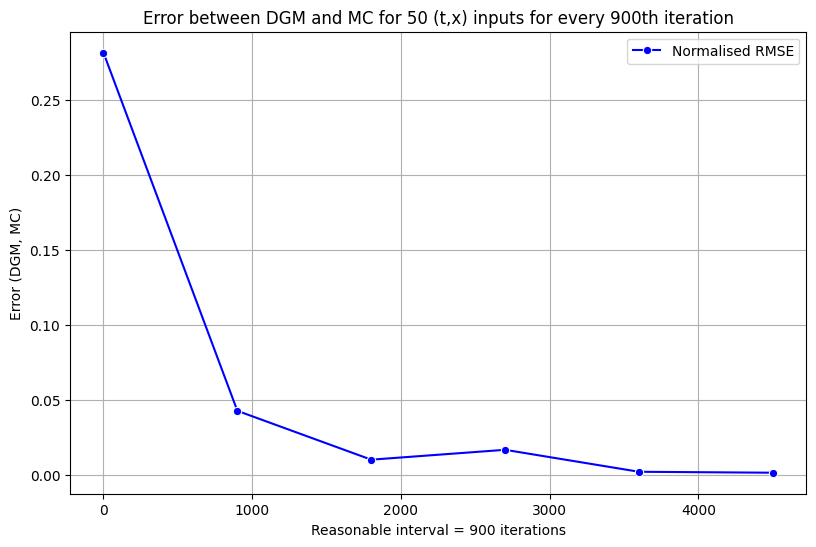

In [43]:
fig, ax = plt.subplots()
sns.lineplot(x = np.arange(0, num_epochs+1, 900), y = error_arr, label = 'Normalised RMSE', marker='o', color = 'b')
plt.xlabel('Reasonable interval = 900 iterations')
plt.ylabel('Error (DGM, MC)')
plt.title('Error between DGM and MC for 50 (t,x) inputs for every 900th iteration')
plt.grid(True)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(9.5)
plt.show()

### Exercise 4.1

In [4]:

hidden_layer_size = 200  # Adjusted hidden layer size
batch_size = 500

# Define two models, one for the control and one for the value function    
model_control = NN.FFN([3, hidden_layer_size, hidden_layer_size, 2],  batch_norm=False)
model_dgm = NN.Net_DGM(2, hidden_layer_size, activation='Tanh')

optimiser_dgm = torch.optim.Adam(model_dgm.parameters(), lr=0.001)
scheduler_dgm = torch.optim.lr_scheduler.MultiStepLR(optimiser_dgm, milestones = (2000, ),gamma=0.1)

optimiser_control = torch.optim.Adam(model_control.parameters(), lr=0.001)
scheduler_control = torch.optim.lr_scheduler.MultiStepLR(optimiser_control, milestones = (800, ),gamma=0.1)

criterion_dgm = torch.nn.MSELoss()
criterion_control = torch.nn.L1Loss()

# Set up parameters so all dimensions fit
RR, HH, CC, MM, DD, SS = LQR.params(batch_size)

T = 0.5

# Epochs for outer loop and epochs for each model training loop
num_epochs = 100
num_epochs_dgm = 100
num_epochs_a = 100

# Initialise a
a = torch.zeros(batch_size, 2, 1).float()

# Target for pde (to get value function)
target_functional = torch.zeros(batch_size)

# Initialise losses for plot
losses_pde = []
losses_control = []


for p in tqdm(range(num_epochs)): # Outer training loop
    for _ in range(num_epochs_dgm): # Train value function, v
        optimiser_dgm.zero_grad()
        
        # Define space and time with random values
        space = torch.rand(batch_size, 2, dtype=torch.float32, requires_grad=True) * 12 - 6
        time = torch.rand(batch_size, 1, dtype = torch.float32, requires_grad=True) * T
        
        space_d = space.unsqueeze(1).detach()

        # Calculate a using the respective model
        arg = torch.cat([time,space], 1)
        a = model_control(arg)
        a = a.detach().unsqueeze(2) # Detach a so model will not try to learn a

        # Calculate u and required gradients
        u_of_tx = model_dgm(time, space)
        grad_u_x = NN.get_gradient(u_of_tx, space).float()
        grad_u_t = NN.get_gradient(u_of_tx, time).float()
        dxx = NN.get_hessian(grad_u_x, space).float()# get_gradient(grad_u_x, space).float()
        
        grad_u_x = grad_u_x.unsqueeze(1)
        grad_u_t = grad_u_t.unsqueeze(1)
        dxx = dxx.unsqueeze(1)
        
        # Calculate value of pde
        trace_matr = SS @ dxx.squeeze(1)
        trace = np.trace(trace_matr.detach().numpy(), axis1=1, axis2 = 2)
        pde = grad_u_t + 0.5 * torch.tensor(trace).reshape(-1, 1, 1) + grad_u_x @ HH @ space_d.reshape(-1, 2, 1) + grad_u_x @ MM @ a + space_d @ CC @ space_d.reshape(-1, 2, 1) + a.reshape(-1, 1, 2) @ DD @ a
        pde = torch.flatten(pde)
        
        MSE_functional = criterion_dgm(pde, target_functional) # Loss on [0, T)

        # Calculate boundary values for boundary condition
        u_of_Tx = model_dgm(torch.tensor([T]).repeat(batch_size, 1), space)
            
        target_terminal = (space_d @ RR.float() @ space_d.reshape(batch_size, 2, 1)).reshape(batch_size, 1) # Boundary condition
        
        MSE_terminal = criterion_dgm(u_of_Tx, target_terminal) # Loss at boundary condition

        loss_pde = MSE_functional + MSE_terminal # Sum up loss on [0, T) and loss at the boundary value T

        losses_pde.append(loss_pde.item()) 
        
        loss_pde.backward(retain_graph=True)
        optimiser_dgm.step()
        scheduler_dgm.step()

    for _ in range(num_epochs_a): # Train optimal control, a
        optimiser_control.zero_grad()

        # Define space and time with random values
        space = torch.rand(batch_size, 2, dtype=torch.float32, requires_grad=True) * 12 - 6
        time = torch.rand(batch_size, 1, dtype = torch.float32, requires_grad=True) * T
        
        space_d = space.unsqueeze(1).detach()
        
        # Calculate u to get the gradient
        u_of_tx = model_dgm(time, space)
        grad_u_x = NN.get_gradient(u_of_tx, space).float()

        grad_u_x = grad_u_x.detach() # Fix the gradient so the model does not learn this value


        # Calculate a
        arg = torch.cat([time,space], 1)
        a = model_control(arg)
        a = a.unsqueeze(2)

        target = torch.zeros(batch_size)

        grad_u_x = grad_u_x.unsqueeze(1)

        # Calculate hamiltonian
        ham = grad_u_x @ HH @ space_d.reshape(-1, 2, 1) + grad_u_x @ MM @ a + space_d @ CC @ space_d.reshape(-1, 2, 1) + a.reshape(-1, 1, 2) @ DD @ a
        ham = torch.flatten(ham)

        loss_control = criterion_control(ham, target)

        losses_control.append(loss_control.item())

        loss_control.backward(retain_graph=True)        

        optimiser_control.step()
        scheduler_control.step()








100%|██████████| 100/100 [30:24<00:00, 18.25s/it]


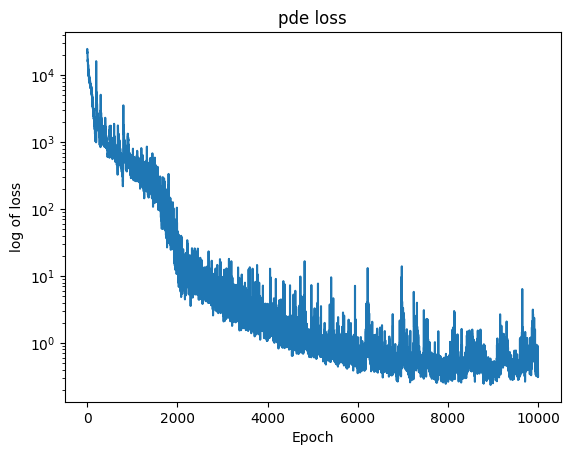

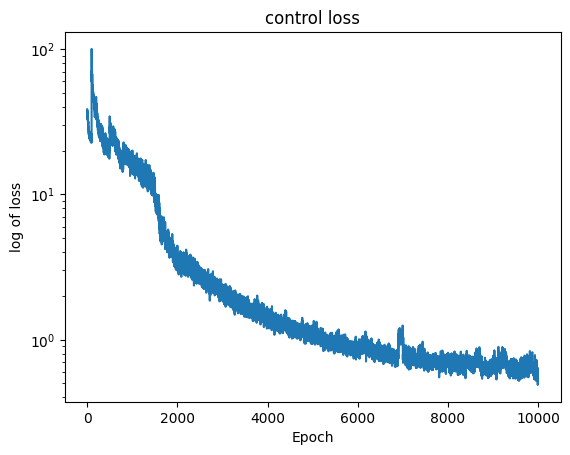

In [9]:
# Plot loss functions with a log y scale
plt.plot(losses_pde)
plt.yscale('log')
plt.title("pde loss")
plt.ylabel("log of loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(losses_control)
plt.yscale('log')
plt.title("control loss")
plt.ylabel("log of loss")
plt.xlabel('Epoch')
plt.show()



The loss tends toward zero but does not go all the way down to zero.

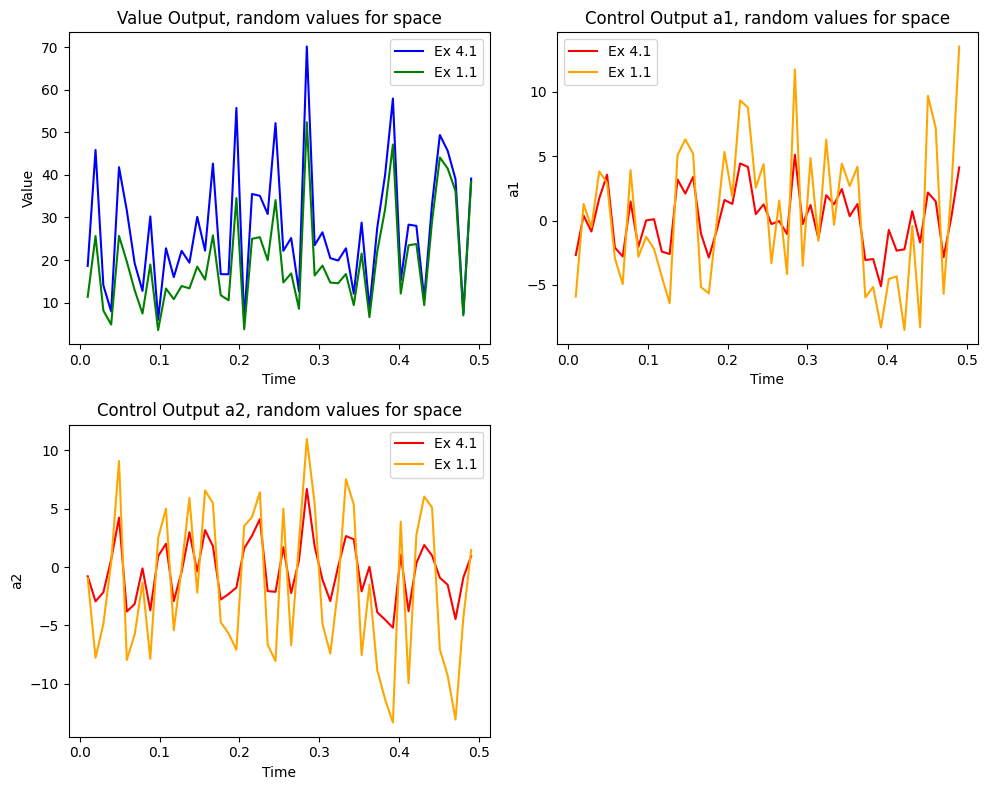

In [10]:
# Generate data
T = 0.5  # Some value for T
space = torch.rand(50, 2, dtype=torch.float32) * 6 - 3
time = torch.linspace(0.01, T-0.01, 50, dtype=torch.float32)
time = time.unsqueeze(1)

# Compute outputs
output_dgm = model_dgm(time, space)
output_control = model_control(torch.cat([time, space], 1))

value = LQR.calculate_value(time.squeeze(1).float(), space.unsqueeze(1).float())
control = LQR.calculate_control(time.squeeze(1).float(), space.unsqueeze(1).float())

# Plotting
plt.figure(figsize=(10, 8))

time = time.detach().numpy()

# Plot value output
plt.subplot(2, 2, 1)
plt.plot(time, output_dgm.detach().numpy(), color='blue', label = 'Ex 4.1')
plt.plot(time, value, color='green', label = 'Ex 1.1')
plt.legend()
plt.title('Value Output, random values for space')
plt.xlabel('Time')
plt.ylabel('Value')

# Plot a1 output
plt.subplot(2, 2, 2)
plt.plot(time, output_control[:, 0].detach().numpy(), color='red', label = 'Ex 4.1')
plt.plot(time, control[:, 0], color='orange', label = 'Ex 1.1')
plt.title('Control Output a1, random values for space')
plt.legend()
plt.xlabel('Time')
plt.ylabel('a1')

# Plot a2 output
plt.subplot(2, 2, 3)
plt.plot(time, output_control[:, 1].detach().numpy(), color='red', label = 'Ex 4.1')
plt.plot(time, control[:, 1], color='orange', label = 'Ex 1.1')
plt.legend()
plt.title('Control Output a2, random values for space')
plt.xlabel('Time')
plt.ylabel('a2')




plt.tight_layout()
plt.show()

We can see that the policy iteration algorithm seems to follow the general trend of the correct values but the errors can be quite large. Presumably this can be fixed by scaling the inputs and outputs and calibrating the model hyperparameters e.g. learning rate, hidden layer size and amount, batch size, etc.